In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/DATA/Sentiment_Analysis_Dataset")
!ls

Mounted at /content/drive
Emotions.txt  glove.6B.50d.txt	model.png


In [2]:
import numpy as np
import pandas as pd

# Loading and Cleaning Data

In [3]:
df = pd.read_csv('Emotions.txt' ,sep=';', names=['text', 'category'], index_col=False)


In [4]:
df.head()

,text,category
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
df.category.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: category, dtype: int64

In [6]:
possible_labels = df.category.unique()
print(possible_labels)

['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


In [7]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

print(label_dict)

{'sadness': 0, 'anger': 1, 'love': 2, 'surprise': 3, 'fear': 4, 'joy': 5}


In [8]:
df['label'] = df.category.replace(label_dict)
df.head(100)

,text,category,label
0,i didnt feel humiliated,sadness,0
1,i can go from feeling so hopeless to so damned...,sadness,0
2,im grabbing a minute to post i feel greedy wrong,anger,1
3,i am ever feeling nostalgic about the fireplac...,love,2
4,i am feeling grouchy,anger,1
...,...,...,...
95,i feel like throwing away the shitty piece of ...,sadness,0
96,im starting to feel wryly amused at the banal ...,joy,5
97,i find every body beautiful and only want peop...,joy,5
98,i hear are owners who feel victimized by their...,sadness,0


In [9]:
df = df.drop(['category'], axis = 1)


In [10]:
df.head(20)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,1
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,1
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,3
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,5
9,i feel romantic too,2


# Training/Validation Split

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
x_train, x_val, y_train, y_val = train_test_split(df['text'], 
                                                  df['label'], 
                                                  test_size=0.20, 
                                                  random_state=17, 
                                                  stratify = df['label'])

In [13]:
x_train=x_train.to_numpy()
x_val=x_val.to_numpy()
y_train=y_train.to_numpy()
y_val=y_val.to_numpy()

In [14]:
x_train[2]

'i feel sarcastic more often than not'

In [15]:
x_train.shape

(12800,)

In [16]:
print(y_train)

[0 5 1 ... 0 0 0]


# Text Preprocessing 

In [17]:
import string
import re
import os
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [18]:
stopwords_english = stopwords.words('english')

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

In [19]:
def process_text(text):
    '''
    Input: 
        text: a string containing a text
    Output:
        text_clean: a list of words containing the processed text
    
    '''
    # remove number 
    text = re.sub('[0-9]', '', text)
    # remove stock market tickers like $GE
    text = re.sub(r'\$\w*', '', text)
    # remove old style text "RT"
    text = re.sub(r'^RT[\s]+', '', text)
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    # remove hashtags
    # only removing the hash # sign from the word
    text = re.sub(r'#', '', text)
    # remove the dates like Mar 30 2013
    text = re.sub('(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s\d{2}\s\d{4}', ' ', text)
    text = re.sub(r'//', '', text)
    # tokenize texts
    text_tokens = word_tokenize(text)
    
    text_clean = []
    
    for word in text_tokens:
       if (word not in stopwords_english and # remove stopwords
            word not in string.punctuation): # remove punctuation
            text_clean.append(word)
            #stem_word = stemmer.stem(word) # stemming word
            #text_clean.append(stem_word)
    
    return  text_clean

# LSTMs in Keras

In [20]:
!pip install keras
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
import tensorflow as tf
np.random.seed(1)

In [21]:
## upload word emebedding file on google drive
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words, words_to_index, index_to_words, word_to_vec_map

In [22]:
words, word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [23]:
def text_to_indices(X, word_to_index, max_len):
    m = X.shape[0]                                   
    
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):
      processed_text = process_text(X[i])
      j = 0
      for w in processed_text:
        if (w in words) & (j < max_len):
          X_indices[i, j] = word_to_index[w]
        j += 1 

    return X_indices

In [24]:
x_train_indices = text_to_indices(x_train, word_to_index, max_len = 20 )

In [25]:
x_train_indices.shape

(12800, 20)

In [26]:
x_train_indices[45]

array([385595., 219372.,  90668.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0.])

In [27]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y


In [28]:
y_train_oh = convert_to_one_hot(y_train, 6)

In [29]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
   
    vocab_len = len(word_to_index)+1                 
    emb_dim = word_to_vec_map["cucumber"].shape[0]      
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [30]:
def lstm_model(input_shape, word_to_vec_map, word_to_index):

    text_to_indices = Input(input_shape, dtype = 'int32')

    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    embeddings = embedding_layer(text_to_indices)   
    
    X = LSTM(128, return_sequences=True)(embeddings)
    
    X = Dropout(0.5)(X)
    
    X = LSTM(128, return_sequences=False)(X)
    
    X = Dropout(0.5)(X)
    
    X = Dense(6)(X)
    
    X = Activation('softmax')(X)
    
    model = Model(inputs = text_to_indices, outputs = X)
    
    return model

In [31]:
max_len= 20
model = lstm_model((max_len,), word_to_vec_map, word_to_index)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 50)            20000050  
_________________________________________________________________
lstm (LSTM)                  (None, 20, 128)           91648     
_________________________________________________________________
dropout (Dropout)            (None, 20, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 774   

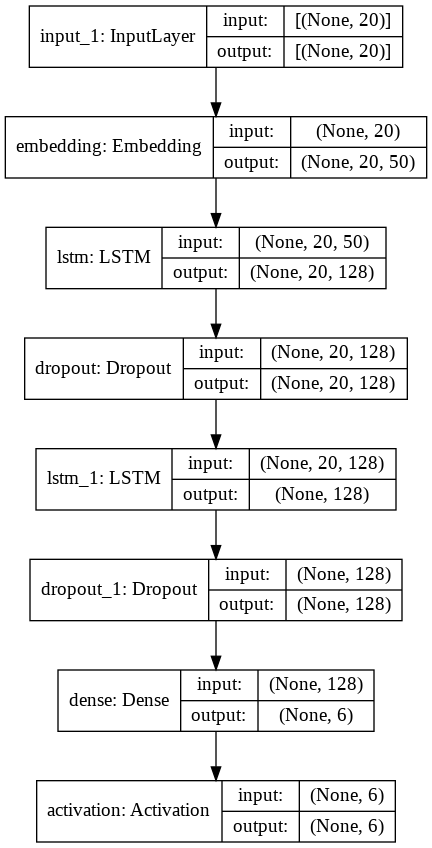

In [32]:
tf.keras.utils.plot_model(model, show_shapes = True, show_layer_names= True)

In [33]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
model.fit(x_train_indices, y_train_oh, epochs = 50, batch_size = 32, shuffle=True)

Epoch 1/50
400/400 [==============================] - 20s 5ms/step - loss: 1.4810 - accuracy: 0.4311
Epoch 2/50
400/400 [==============================] - 2s 5ms/step - loss: 1.1548 - accuracy: 0.5653
Epoch 3/50
400/400 [==============================] - 2s 5ms/step - loss: 0.9116 - accuracy: 0.6677
Epoch 4/50
400/400 [==============================] - 2s 5ms/step - loss: 0.7018 - accuracy: 0.7513
Epoch 5/50
400/400 [==============================] - 2s 5ms/step - loss: 0.5392 - accuracy: 0.8121
Epoch 6/50
400/400 [==============================] - 2s 5ms/step - loss: 0.4325 - accuracy: 0.8498
Epoch 7/50
400/400 [==============================] - 2s 5ms/step - loss: 0.3634 - accuracy: 0.8679
Epoch 8/50
400/400 [==============================] - 2s 5ms/step - loss: 0.3057 - accuracy: 0.8899
Epoch 9/50
400/400 [==============================] - 2s 5ms/step - loss: 0.2690 - accuracy: 0.9046
Epoch 10/50
400/400 [==============================] - 2s 5ms/step - loss: 0.2289 - accuracy: 0.914

In [35]:
X_val_indices = text_to_indices(x_val, word_to_index, max_len = 20)
Y_val_oh = convert_to_one_hot(y_val, C = 6)
loss, acc = model.evaluate(X_val_indices, Y_val_oh)

print("validation accuracy = ", acc)

100/100 [==============================] - 2s 3ms/step - loss: 0.6665 - accuracy: 0.8628
validation accuracy =  0.8628125190734863


# Test your own sentence 

In [45]:
model.save('Sentiment_Analysis_LSTMs_Model.h5')

In [41]:
from keras.models import load_model

In [46]:
loaded_model = load_model('./Sentiment_Analysis_LSTMs_Model.h5')

In [47]:
## Predict emotion 
input_string = np.array(['why you are angry today'])
X = text_to_indices(input_string, word_to_index, max_len = 20)
prediction = np.argmax(loaded_model.predict(X))
labels = {'sadness': 0, 'anger': 1, 'love': 2, 'surprise': 3, 'fear': 4, 'joy': 5}
for key, value in labels.items():
  if prediction == value:
    print("predicted emotion is: " + str(key))

predicted emotion is: anger


# Deployment

In [59]:
loaded_model = load_model('./Sentiment_Analysis_LSTMs_Model.h5')

In [63]:
!pip install flask-ngrok

In [76]:
from flask import Flask, request
from flask_ngrok import run_with_ngrok

In [95]:
app = Flask(__name__)
run_with_ngrok(app)

In [96]:
@app.route("/")
def home():
    return "It is running..."

@app.route('/predict', methods=["GET"])
def api_predict():
  sentence = request.args.get("sentence")
  input_string = np.array([sentence])
  X = text_to_indices(input_string, word_to_index, max_len = 20)
  prediction = np.argmax(loaded_model.predict(X))
  labels = {'sadness': 0, 'anger': 1, 'love': 2, 'surprise': 3, 'fear': 4, 'joy': 5}
  for key, value in labels.items():
    if prediction == value:
      emotion = key
       
  return "<h1>Predicted emotion is: <h1>" + str(key)

app.run()


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://ab0d74e346b5.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [02/Aug/2021 12:03:00] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Aug/2021 12:03:01] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [02/Aug/2021 12:03:48] "GET /predict?sentence=i%20could%20either%20watch%20it%20happen%20or%20be%20apart%20of%20it HTTP/1.1" 200 -
127.0.0.1 - - [02/Aug/2021 12:03:48] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [02/Aug/2021 12:03:50] "GET /predict?sentence=i%20could%20either%20watch%20it%20happen%20or%20be%20apart%20of%20it HTTP/1.1" 200 -
